GaussianCopula Model
====================

In this guide we will go through a series of steps that will let you
discover functionalities of the `GaussianCopula` model, including how
to:

-   Create an instance of a `GaussianCopula`.
-   Fit the instance to your data.
-   Generate synthetic versions of your data.
-   Use `GaussianCopula` to anonymize PII information.
-   Customize the data transformations to improve the learning process.
-   Specify the column distributions to improve the output quality.

What is GaussianCopula?
-----------------------

The `sdv.tabular.GaussianCopula` model is based on [copula
funtions](https://en.wikipedia.org/wiki/Copula_%28probability_theory%29).

In mathematical terms, a *copula* is a distribution over the unit cube
${\displaystyle [0,1]^{d}}$ which is constructed from a multivariate
normal distribution over ${\displaystyle \mathbb {R} ^{d}}$ by using the
probability integral transform. Intuitively, a *copula* is a
mathematical function that allows us to describe the joint distribution
of multiple random variables by analyzing the dependencies between their
marginal distributions.

Let\'s now discover how to learn a dataset and later on generate
synthetic data with the same format and statistical properties by using
the `GaussianCopula` model.

Quick Usage
-----------

We will start by loading one of our demo datasets, the
`student_placements`, which contains information about MBA students that
applied for placements during the year 2020.

In [1]:
from sdv.demo import load_tabular_demo

data = load_tabular_demo('student_placements')
data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


As you can see, this table contains information about students which
includes, among other things:

-   Their id and gender
-   Their grades and specializations
-   Their work experience
-   The salary that they where offered
-   The duration and dates of their placement

You will notice that there is data with the following characteristics:

-   There are float, integer, boolean, categorical and datetime values.
-   There are some variables that have missing data. In particular, all
    the data related to the placement details is missing in the rows
    where the student was not placed.

Let us use the `GaussianCopula` to learn this data and then sample
synthetic data about new students to see how well de model captures the
characteristics indicated above. In order to do this you will need to:

-   Import the `sdv.tabular.GaussianCopula` class and create an instance
    of it.
-   Call its `fit` method passing our table.
-   Call its `sample` method indicating the number of synthetic rows
    that you want to generate.

In [2]:
from sdv.tabular import GaussianCopula

model = GaussianCopula()
model.fit(data)

<div class="alert alert-info">

**Note**

Notice that the model `fitting` process took care of transforming the
different fields using the appropriate [Reversible Data
Transforms](http://github.com/sdv-dev/RDT) to ensure that the data has a
format that the `GaussianMultivariate` model can handle.

</div>

### Generate synthetic data from the model

Once the modeling has finished you are ready to generate new synthetic
data by calling the `sample` method from your model passing the number
of rows that we want to generate.

In [3]:
new_data = model.sample(200)

This will return a table identical to the one which the model was fitted
on, but filled with new data which resembles the original one.

In [4]:
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17373,M,58.387620,52.964588,Science,53.696312,Sci&Tech,False,0,74.988191,Mkt&HR,78.026614,NaN,False,NaT,NaT,NaN
1,17282,F,75.098608,72.182691,Commerce,74.472530,Comm&Mgmt,False,0,64.837870,Mkt&Fin,69.220672,26981.997110,True,2020-01-25,2020-09-10,3.0
2,17400,M,70.736428,87.743467,Commerce,63.050484,Comm&Mgmt,False,0,97.235664,Mkt&Fin,55.693988,32169.639395,True,2020-01-05,2020-08-29,12.0
3,17432,F,76.064733,62.604252,Science,67.130743,Sci&Tech,False,0,59.377329,Mkt&HR,67.043891,NaN,False,NaT,NaT,NaN
4,17309,M,75.139628,70.712957,Science,72.043976,Sci&Tech,False,0,83.491147,Mkt&Fin,66.598345,32140.400456,True,2020-01-15,2020-05-30,3.0


<div class="alert alert-info">

**Note**

You can control the number of rows by specifying the number of `samples`
in the `model.sample(<num_rows>)`. To test, try `model.sample(10000)`.
Note that the original table only had \~200 rows.

</div>

### Save and Load the model

In many scenarios it will be convenient to generate synthetic versions
of your data directly in systems that do not have access to the original
data source. For example, if you may want to generate testing data on
the fly inside a testing environment that does not have access to your
production database. In these scenarios, fitting the model with real
data every time that you need to generate new data is feasible, so you
will need to fit a model in your production environment, save the fitted
model into a file, send this file to the testing environment and then
load it there to be able to `sample` from it.

Let\'s see how this process works.

#### Save and share the model

Once you have fitted the model, all you need to do is call its `save`
method passing the name of the file in which you want to save the model.
Note that the extension of the filename is not relevant, but we will be
using the `.pkl` extension to highlight that the serialization protocol
used is [pickle](https://docs.python.org/3/library/pickle.html).

In [5]:
model.save('my_model.pkl')

This will have created a file called `my_model.pkl` in the same
directory in which you are running SDV.

<div class="alert alert-info">

**Important**

If you inspect the generated file you will notice that its size is much
smaller than the size of the data that you used to generate it. This is
because the serialized model contains **no information about the
original data**, other than the parameters it needs to generate
synthetic versions of it. This means that you can safely share this
`my_model.pkl` file without the risk of disclosing any of your real
data!

</div>

#### Load the model and generate new data

The file you just generated can be send over to the system where the
synthetic data will be generated. Once it is there, you can load it
using the `GaussianCopula.load` method, and then you are ready to sample
new data from the loaded instance:

In [6]:
loaded = GaussianCopula.load('my_model.pkl')
new_data = loaded.sample(200)

<div class="alert alert-warning">

**Warning**

Notice that the system where the model is loaded needs to also have
`sdv` installed, otherwise it will not be able to load the model and use
it.

</div>

### Specifying the Primary Key of the table

One of the first things that you may have noticed when looking that demo
data is that there is a `student_id` column which acts as the primary
key of the table, and which is supposed to have unique values. Indeed,
if we look at the number of times that each value appears, we see that
all of them appear at most once:

In [7]:
data.student_id.value_counts().max()

1

However, if we look at the synthetic data that we generated, we observe
that there are some values that appear more than once:

In [8]:
new_data[new_data.student_id == new_data.student_id.value_counts().index[0]]

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
104,17269,M,87.483943,110.317592,Commerce,70.759381,Sci&Tech,False,1,58.502162,Mkt&Fin,59.535882,28779.475053,True,2020-03-17,2020-07-11,3.0
143,17269,M,57.239499,69.013186,Science,55.543813,Sci&Tech,False,0,64.298186,Mkt&Fin,56.241848,NaN,False,NaT,NaT,NaN
147,17269,F,77.674823,93.487394,Commerce,69.815706,Comm&Mgmt,False,0,72.534136,Mkt&Fin,76.264659,21869.667077,True,2020-06-28,2020-08-06,3.0
186,17269,M,60.076974,63.953675,Commerce,62.053933,Comm&Mgmt,False,0,57.228118,Mkt&Fin,68.912877,NaN,False,NaT,NaT,NaN


This happens because the model was not notified at any point about the
fact that the `student_id` had to be unique, so when it generates new
data it will provoke collisions sooner or later. In order to solve this,
we can pass the argument `primary_key` to our model when we create it,
indicating the name of the column that is the index of the table.

In [9]:
model = GaussianCopula(
    primary_key='student_id'
)
model.fit(data)
new_data = model.sample(200)
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,M,61.409870,70.667918,Commerce,68.541709,Comm&Mgmt,False,-1,56.980574,Mkt&HR,54.650546,22104.019619,True,2020-01-28,2020-06-03,3.0
1,1,F,79.617273,71.741462,Science,89.106488,Comm&Mgmt,False,0,72.044255,Mkt&Fin,75.794918,25575.336247,True,2020-01-11,2020-04-07,3.0
2,2,F,55.734193,48.669853,Arts,59.631505,Comm&Mgmt,False,-1,89.264011,Mkt&HR,59.330819,19941.250872,True,2020-01-04,2020-03-10,3.0
3,3,M,72.383976,58.972381,Commerce,77.077422,Comm&Mgmt,False,1,71.095514,Mkt&Fin,65.244331,26817.309806,True,2020-01-08,2020-07-13,3.0
4,4,M,67.577519,69.380068,Science,69.591472,Sci&Tech,False,0,83.619679,Mkt&Fin,61.201599,NaN,False,NaT,NaT,NaN


As a result, the model will learn that this column must be unique and
generate a unique sequence of values for the column:

In [10]:
new_data.student_id.value_counts().max()

1

### Anonymizing Personally Identifiable Information (PII)

There will be many cases where the data will contain Personally
Identifiable Information which we cannot disclose. In these cases, we
will want our Tabular Models to replace the information within these
fields with fake, simulated data that looks similar to the real one but
does not contain any of the original values.

Let\'s load a new dataset that contains a PII field, the
`student_placements_pii` demo, and try to generate synthetic versions of
it that do not contain any of the PII fields.

<div class="alert alert-info">

**Note**

The `student_placements_pii` dataset is a modified version of the
`student_placements` dataset with one new field, `address`, which
contains PII information about the students. Notice that this additional
`address` field has been simulated and does not correspond to data from
the real users.

</div>

In [11]:
data_pii = load_tabular_demo('student_placements_pii')
data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,"70304 Baker Turnpike\nEricborough, MS 15086",M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,"805 Herrera Avenue Apt. 134\nMaryview, NJ 36510",M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,"3702 Bradley Island\nNorth Victor, FL 12268",M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,Unit 0879 Box 3878\nDPO AP 42663,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 3...",M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


If we use our tabular model on this new data we will see how the
synthetic data that it generates discloses the addresses from the real
students:

In [12]:
model = GaussianCopula(
    primary_key='student_id',
)
model.fit(data_pii)
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"5449 Evans Well\nPort Brett, DE 56274",F,66.180613,59.831272,Commerce,76.378165,Comm&Mgmt,False,0,60.442591,Mkt&Fin,63.016139,25171.387442,True,2020-02-06,2020-08-17,3.0
1,1,"653 Mark Forge Suite 804\nBillyview, KS 58544",M,85.130150,85.654018,Commerce,63.438194,Comm&Mgmt,False,0,96.773614,Mkt&HR,65.702341,32015.670281,True,2020-01-08,2020-07-04,3.0
2,2,"09592 Walter Pines\nRobertstad, HI 86102",F,81.605599,65.939516,Science,76.889287,Comm&Mgmt,False,1,97.514417,Mkt&Fin,74.508167,30083.577498,True,2020-01-02,2020-08-28,12.0
3,3,"786 Shane Bridge Suite 165\nNorth Douglas, GA ...",F,56.055318,59.821817,Commerce,50.523135,Comm&Mgmt,False,0,67.130213,Mkt&Fin,55.812613,33257.038243,True,2020-05-24,2020-12-02,3.0
4,4,"36924 Jamie Cliffs\nPhillipmouth, TX 21393",F,72.260550,56.415165,Science,63.987574,Others,False,1,67.938208,Mkt&HR,69.764694,27715.657611,True,2020-01-04,2020-08-02,12.0


More specifically, we can see how all the addresses that have been
generated actually come from the original dataset:

In [13]:
new_data_pii.address.isin(data_pii.address).sum()

200

In order to solve this, we can pass an additional argument
`anonymize_fields` to our model when we create the instance. This
`anonymize_fields` argument will need to be a dictionary that contains:

-   The name of the field that we want to anonymize.
-   The category of the field that we want to use when we generate fake
    values for it.

The list complete list of possible categories can be seen in the [Faker
Providers](https://faker.readthedocs.io/en/master/providers.html) page,
and it contains a huge list of concepts such as:

-   name
-   address
-   country
-   city
-   ssn
-   credit_card_number
-   credit_card_expire
-   credit_card_security_code
-   email
-   telephone
-   \...

In this case, since the field is an e-mail address, we will pass a
dictionary indicating the category `address`

In [14]:
model = GaussianCopula(
    primary_key='student_id',
    anonymize_fields={
        'address': 'address'
    }
)
model.fit(data_pii)

As a result, we can see how the real `address` values have been replaced
by other fake addresses:

In [15]:
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"9043 Carol Parks Suite 263\nWalterston, MT 44378",M,72.221784,57.946745,Science,66.017455,Sci&Tech,False,0,81.148549,Mkt&HR,59.168630,NaN,False,NaT,NaT,3.0
1,1,"258 Frank Wells Suite 366\nLake Jasonmouth, MT...",F,46.896475,57.314392,Commerce,72.303363,Comm&Mgmt,False,0,77.249931,Mkt&Fin,63.402252,NaN,False,NaT,NaT,NaN
2,2,USNS Vincent\nFPO AE 10509,M,80.260598,60.251931,Commerce,72.205782,Comm&Mgmt,False,1,62.610035,Mkt&Fin,53.313822,25789.084759,True,2020-01-28,2020-10-27,3.0
3,3,"488 Derrick Rue Suite 229\nMedinaland, RI 81352",F,44.024446,63.517838,Commerce,60.366966,Others,False,0,55.366576,Mkt&Fin,65.619618,NaN,False,NaT,NaT,NaN
4,4,"293 Hall Divide Apt. 725\nMendozamouth, IN 46443",M,65.741258,79.950693,Commerce,67.103512,Comm&Mgmt,False,-1,57.404917,Mkt&Fin,51.133429,26874.289094,True,2020-03-02,2020-11-04,12.0


Which means that none of the original addresses can be found in the
sampled data:

In [16]:
data_pii.address.isin(new_data_pii.address).sum()

0

Advanced Usage
--------------

Now that we have discovered the basics, let\'s go over a few more
advanced usage examples and see the different arguments that we can pass
to our `GaussianCopula` Model in order to customize it to our needs.

### How to set transforms to use?

One thing that you may have noticed when executing the previous steps is
that the fitting process took much longer on the
`student_placements_pii` dataset than it took on the previous version
that did not contain the student `address`. This happens because the
`address` field is interpreted as a categorical variable, which the
`GaussianCopula` [one-hot
encoded](https://en.wikipedia.org/wiki/One-hot) generating 215 new
columns that it had to learn afterwards.

This transformation, which in this case was very inefficient, happens
because the Tabular Models apply [Reversible Data
Transforms](https://github.com/sdv-dev/RDT) under the hood to transform
all the non-numerical variables, which the underlying models cannot
handle, into numerical representations which they can properly work
with. In the case of the `GaussianCopula`, the default transformation is
a One-Hot encoding, which can work very well with variables that have a
little number of different values, but which is very inefficient in
cases where there is a large number of values.

For this reason, the Tabular Models have an additional argument called
`field_transformers` that let you select which transformer to apply to
each column. This `field_transformers` argument must be passed as a
`dict` which contains the name of the fields for which we want to use a
transformer different than the default, and the name of the transformer
that we want to use.

Possible transformer names are:

-   `integer`: Uses a `NumericalTransformer` of dtype `int`.
-   `float`: Uses a `NumericalTransformer` of dtype `float`.
-   `categorical`: Uses a `CategoricalTransformer` without gaussian
    noise.
-   `categorical_fuzzy`: Uses a `CategoricalTransformer` adding gaussian
    noise.
-   `one_hot_encoding`: Uses a `OneHotEncodingTransformer`.
-   `label_encoding`: Uses a `LabelEncodingTransformer`.
-   `boolean`: Uses a `BooleanTransformer`.
-   `datetime`: Uses a `DatetimeTransformer`.

**NOTE**: For additional details about each one of the transformers,
please visit [RDT](https://github.com/sdv-dev/RDT)

Let\'s now try to improve the previous fitting process by changing the
transformer that we use for the `address` field to something other than
the default. As an example, we will use the `label_encoding`
transformer, which instead of generating one column for each possible
value, it just replaces each value with a unique integer value.

In [17]:
model = GaussianCopula(
    primary_key='student_id',
    anonymize_fields={
        'address': 'address'
    },
    field_transformers={
        'address': 'label_encoding'
    }
)
model.fit(data_pii)
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"13894 Knox Path\nNew Warrenbury, VT 68690",F,61.446377,66.912114,Commerce,78.547991,Comm&Mgmt,False,0,87.218563,Mkt&Fin,56.069760,24227.007780,True,2020-06-04,2020-08-12,3.0
1,1,"49018 Thomas Fields\nAprilview, IN 51497",M,70.612219,62.330744,Commerce,61.379353,Comm&Mgmt,False,1,87.821987,Mkt&Fin,57.539200,31610.023673,True,2020-03-09,2020-12-05,12.0
2,2,USNV Garcia\nFPO AP 94993,F,65.407636,66.245252,Commerce,62.997327,Sci&Tech,False,1,68.359459,Mkt&HR,58.317207,NaN,False,NaT,NaT,NaN
3,3,"10350 Donovan Lodge\nPort Brandi, GA 75359",M,65.410272,45.880416,Science,60.219863,Sci&Tech,False,0,55.366487,Mkt&Fin,59.489872,29747.798495,True,2020-02-01,2020-08-22,3.0
4,4,"71372 Zimmerman Oval Apt. 006\nJessicaville, A...",M,64.034914,72.294830,Commerce,63.277342,Comm&Mgmt,False,0,64.027038,Mkt&HR,52.922011,36037.616309,True,2020-01-02,2020-08-04,3.0


### Exploring the Probability Distributions

During the previous steps, every time we fitted the `GaussianCopula` it
performed the following operations:

1.  Learn the format and data types of the passed data
2.  Transform the non-numerical and null data using [Reversible Data
    Transforms](https://github.com/sdv-dev/RDT) to obtain a fully
    numerical representation of the data from which we can learn the
    probability distributions.
3.  Learn the probability distribution of each column from the table
4.  Transform the values of each numerical column by converting them to
    their marginal distribution CDF values and then applying an inverse
    CDF transformation of a standard normal on them.
5.  Learn the correlations of the newly generated random variables.

After this, when we used the model to generate new data for our table
using the `sample` method, it did:

5.  Sample from a Multivariate Standard Normal distribution with the
    learned correlations.
6.  Revert the sampled values by computing their standard normal CDF and
    then applying the inverse CDF of their marginal distributions.
7.  Revert the RDT transformations to go back to the original data
    format.

As you can see, during these steps the *Marginal Probability
Distributions* have a very important role, since the `GaussianCopula`
had to learn and reproduce the individual distributions of each column
in our table. We can explore the distributions which the
`GaussianCopula` used to model each column using its `get_distributions`
method:

In [18]:
model = GaussianCopula(
    primary_key='student_id'
)
model.fit(data)
distributions = model.get_distributions()

This will return us a `dict` which contains the name of the distribution
class used for each column:

In [19]:
distributions

{'gender#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'gender#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'second_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'high_perc': 'copulas.univariate.log_laplace.LogLaplace',
 'high_spec#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'high_spec#1': 'copulas.univariate.gamma.GammaUnivariate',
 'high_spec#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'degree_perc': 'copulas.univariate.student_t.StudentTUnivariate',
 'degree_type#0': 'copulas.univariate.student_t.StudentTUnivariate',
 'degree_type#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'degree_type#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'work_experience': 'copulas.univariate.student_t.StudentTUnivariate',
 'experience_years': 'copulas.univariate.gaussian.GaussianUnivariate',
 'employability_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'mba_spec#0': 'copulas.univariate.gamma.GammaUnivar

<div class="alert alert-info">

**Note**

In this list we will see multiple distributions for each one of the
columns that we have in our data. This is because the RDT
transformations used to encode the data numerically often use more than
one column to represent each one of the input variables.

</div>

Let\'s explore the individual distribution of one of the columns in our
data to better understand how the `GaussianCopula` processed them and
see if we can improve the results by manually specifying a different
distribution. For example, let\'s explore the `experience_years` column
by looking at the frequency of its values within the original data:

In [20]:
data.experience_years.value_counts()

0    141
1     65
2      8
3      1
Name: experience_years, dtype: int64

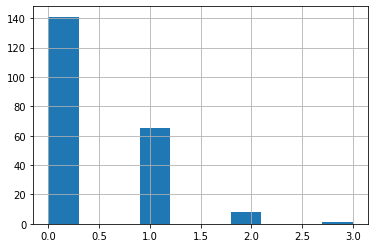

In [21]:
data.experience_years.hist();

By observing the data we can see that the behavior of the values in this
column is very similar to a Gamma or even some types of Beta
distribution, where the majority of the values are 0 and the frequency
decreases as the values increase.

Was the `GaussianCopula` able to capture this distribution on its own?

In [22]:
distributions['experience_years']

'copulas.univariate.gaussian.GaussianUnivariate'

It seems that the it was not, as it rather thought that the behavior was
closer to a Gaussian distribution. And, as a result, we can see how the
generated values now contain negative values which are invalid for this
column:

In [23]:
new_data.experience_years.value_counts()

 0    102
 1     74
-1     14
 2     10
Name: experience_years, dtype: int64

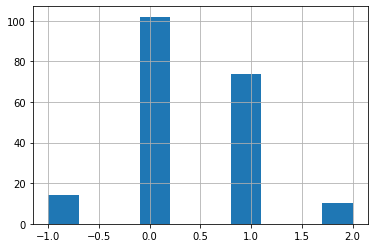

In [24]:
new_data.experience_years.hist();

Let\'s see how we can improve this situation by passing the
`GaussianCopula` the exact distribution that we want it to use for this
column.

### Setting distributions for individual variables

The `GaussianCopula` class offers the possibility to indicate which
distribution to use for each one of the columns in the table, in order
to solve situations like the one that we just described. In order to do
this, we need to pass a `field_distributions` argument with `dict` that
indicates the distribution that we want to use for each column.

Possible values for the distribution argument are:

-   `univariate`: Let `copulas` select the optimal univariate
    distribution. This may result in non-parametric models being used.
-   `parametric`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to parametric distributions
    only.
-   `bounded`: Let `copulas` select the optimal univariate distribution,
    but restrict the selection to bounded distributions only. This may
    result in non-parametric models being used.
-   `semi_bounded`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to semi-bounded
    distributions only. This may result in non-parametric models being
    used.
-   `parametric_bounded`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to parametric and bounded
    distributions only.
-   `parametric_semi_bounded`: Let `copulas` select the optimal
    univariate distribution, but restrict the selection to parametric
    and semi-bounded distributions only.
-   `gaussian`: Use a Gaussian distribution.
-   `gamma`: Use a Gamma distribution.
-   `beta`: Use a Beta distribution.
-   `student_t`: Use a Student T distribution.
-   `gaussian_kde`: Use a GaussianKDE distribution. This model is
    non-parametric, so using this will make `get_parameters` unusable.
-   `truncated_gaussian`: Use a Truncated Gaussian distribution.

Let\'s see what happens if we make the `GaussianCopula` use the `gamma`
distribution for our column.

In [25]:
from sdv.tabular import GaussianCopula

model = GaussianCopula(
    primary_key='student_id',
    field_distributions={
        'experience_years': 'gamma'
    }
)
model.fit(data)

After this, we can see how the `GaussianCopula` used the indicated
distribution for the `experience_years` column

In [26]:
model.get_distributions()['experience_years']

'copulas.univariate.gamma.GammaUnivariate'

And, as a result, now we can see how the generated data now have a
behavior which is closer to the original data and always stays within
the valid values range.

In [27]:
new_data = model.sample(len(data))
new_data.experience_years.value_counts()

0    198
1     17
Name: experience_years, dtype: int64

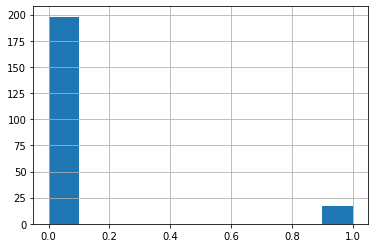

In [28]:
new_data.experience_years.hist();

<div class="alert alert-info">

**Note**

Even though there are situations like the one show above where manually
choosing a distribution seems to give better results, in most cases the
`GaussianCopula` will be able to find the optimal distribution on its
own, making this manual search of the marginal distributions necessary
on very little occasions.

</div>

### How do I specify constraints?

If you look closely at the data you may notice that some properties were
not completely captured by the model. For example, you may have seen
that sometimes the model produces an `experience_years` number greater
than `0` while also indicating that `work_experience` is `False`. These
type of properties are what we call `Constraints` and can also be
handled using `SDV`. For further details about them please visit the
[Handling Constraints](04_Handling_Constraints.ipynb) guide.

### Can I evaluate the Synthetic Data?

A very common question when someone starts using **SDV** to generate
synthetic data is: *\"How good is the data that I just generated?\"*

In order to answer this question, **SDV** has a collection of metrics
and tools that allow you to compare the *real* that you provided and the
*synthetic* data that you generated using **SDV** or any other tool.

You can read more about this in the [Evaluating Synthetic Data Generators](
05_Evaluating_Synthetic_Data_Generators.ipynb) guide.